In [1]:
from tcrpower import NBVarTCRCountModel, NBVarCalibrator, TCRPowerCalculator
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib as mpl

font = {'family' : 'DejaVu Sans',
        'size'   : 14}

mpl.rc('font', **font)

In [2]:
TOTAL_READS = 2*10**6 #The total number of sequencing reads (spike-in or other).
CHAIN = "A"

TRUE_TCR_COL = "True_TR{}_fraction".format(CHAIN)
READCOUNT_COL = "TR{}_readcount".format(CHAIN)

tcr_spikein_data = pd.read_csv("testdata/tcr_readcounts.csv") #Change this path to load your own data
tcr_spikein_data

,True_TRA_fraction,TRA_readcount
0,9.981833e-07,0
1,9.981833e-07,0
2,9.981833e-07,0
3,9.981833e-07,1
4,9.981833e-07,0
...,...,...
217,9.981833e-04,175
218,9.981833e-04,261
219,9.981833e-04,215
220,9.981833e-04,390


# Fit a negative binomial model to the data

In [3]:
modelcalib = NBVarCalibrator(tcr_spikein_data[TRUE_TCR_COL].values,
                             tcr_spikein_data[READCOUNT_COL].values, 
                             TOTAL_READS)

negbin_modelfit = modelcalib.fit()

powercalc = TCRPowerCalculator(negbin_modelfit)
print(negbin_modelfit)

Fitted Negative Binomial Model
	Read Efficiency   = 0.2867403872229758
	Eta               = 2.135379267939708
	Lambda            = 1.8529095745230972


<ipython-input-4-842413a47b09>:35: RuntimeWarning: divide by zero encountered in log10
  nblow_log10 = np.log10(nb_low)


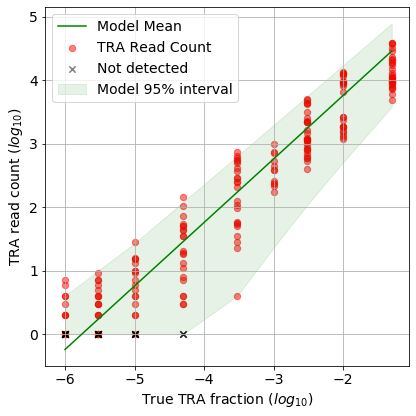

In [4]:
#Plot the data
fig = plt.figure(figsize = (6, 6))
ax = fig.subplots(1, 1)

nonzero = tcr_spikein_data[READCOUNT_COL] >0

ax.scatter(np.log10(tcr_spikein_data[TRUE_TCR_COL][nonzero]),
           np.log10(tcr_spikein_data[READCOUNT_COL][nonzero]),
           label = "TR{} Read Count".format(CHAIN),
           alpha = 0.5,
           s = 40,
           color ='r')

ax.scatter(np.log10(tcr_spikein_data[TRUE_TCR_COL][~nonzero]),
           [0]*np.logical_not(nonzero).sum(),
            label = "Not detected",
            alpha = 0.5,
            s = 40,
            marker = "x",
            color ='k')

ax.grid()
ax.set_xlabel("True TR{} ".format(CHAIN) +  "fraction $(log_{10})$")
ax.set_ylabel("TR{} ".format(CHAIN) + "read count $(log_{10})$")

#Plot the mean and 95% prediction interval of the model
INTERVAL_SIZE = 0.95

tra_fractions = tcr_spikein_data[TRUE_TCR_COL].unique()
tra_fractions.sort()
nb_means = powercalc.predict_mean(tra_fractions, TOTAL_READS)
nb_low, nb_high = powercalc.get_prediction_interval(tra_fractions,
                                                    TOTAL_READS,
                                                    INTERVAL_SIZE)
nblow_log10 = np.log10(nb_low)
nblow_log10[nb_low == 0] = 0

ax.plot(np.log10(tra_fractions),
        np.log10(nb_means),
        "g",
        label = "Model Mean")
    
ax.fill_between(np.log10(tra_fractions),
                nblow_log10,
                np.log10(nb_high),
                alpha = 0.1,
                color = "g",
                label = "Model {:d}% interval".format(int(100*INTERVAL_SIZE)))
plt.legend()
plt.tight_layout()
plt.savefig("testdata/readcounts_model.png")

# Create a detection power plot 

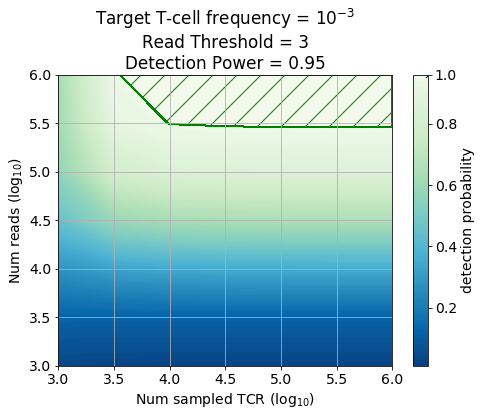

In [6]:
TARGET_TCR_FREQ = 1.0e-3 # The target TCR frequency
DETECT_THRESH = 3 # The read threshold for detection
PC_RANGE = [3, 6] #Plot upper and lower log10 limits of cell and read count
DETECT_POWER = 0.95

fig = plt.figure(figsize = (7, 6))
ax = fig.subplots(1, 1)

log10_reads_range = np.arange(PC_RANGE[0], PC_RANGE[1] + 0.5, 0.5)
log10_cells_range = log10_reads_range
    
X, Y = np.meshgrid(log10_cells_range,
                   log10_reads_range)

Z = np.array([[powercalc.predict_detection_probability_2step(TARGET_TCR_FREQ,
                                                             10**num_reads,
                                                             10**num_cells,
                                                             detect_thresh = DETECT_THRESH)
                   for num_cells in log10_cells_range]
                   for num_reads in log10_reads_range])

levels = np.arange(0.01, DETECT_POWER + 0.01, 0.01)
levels = np.hstack([levels, [1.0]])


hatches = [None]*(len(levels) -2) + ["/"]*2
cp = ax.contourf(X, Y, Z, 
                levels = levels,
                cmap = mpl.cm.get_cmap("GnBu_r"),
                hatches = hatches)

cp.collections[-1].set_edgecolor("green")

cbar = fig.colorbar(cp,
                    boundaries = [0, 1.0],
                    ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0])
cbar.set_label("detection probability")


title = 'Target T-cell frequency = $10^{' + "{}".format(int(np.log10(float(TARGET_TCR_FREQ)))) + '}$'
title += "\nRead Threshold = {}".format(DETECT_THRESH)
title += "\nDetection Power = {}".format(DETECT_POWER)

ax.set_title(title)
ax.set_xlabel("Num sampled TCR $(\log_{10})$")
ax.set_ylabel("Num reads $(\log_{10})$")
ax.grid()
plt.tight_layout()
plt.savefig("testdata/powercalc.png")